# Milestone

In this assignment, we implement a simulation for estimating profit made at a sandwich shop. Not suprisingly, the sandwich shop earns money every time a customer buys a sandwich. However, the inputs to the sandwich cost money. The daily profit is the amount customers pay for the sandwiches minus the cost of the inputs. Unlike the simulations we saw in class, this time we need to set up simulations for multiple dependent events, so we worked out some of the solution and leave you to fill in the gaps as pointed out in the assignment.

## Problem statement

To keep things simple, we make the following assumptions:

- The shop bakes its own bread, and the bread must be used on the day it is made. The customers can select one of three types of bread, white, wheat, and multigrain.
- The number of each type of bread baked in the sandwich shop is fixed. Presumably the shop manager has a plan for the day, and the bread is baked in advance of the customer arrivals.
- The probability that each customer chooses a particular type of bread is fixed and known. There probabilities are 50% for white bread, 25% for wheat and 25% for multigrain. 
- If a customer's choice of bread is not available the customer leaves the shop without buying a sandwich.
- The only perishable input which must be discarded at the end of each day is the bread. 
- Customers do NOT stop coming to the sandwich shop as a result of not finding their bread choice. In other words, we will not consider the possiblity of attrition.

In order to develop an overall profitability model we must run through the following steps:

1. Simulate the number of customer arrivals on a given day.
1. Simulate supply and demand for each bread. Supply will be deterministic, but demand will depend on the number of customers who come on a given day and which type of bread they choose. 
1. Once we have supply and demand, we can finally simulate profit. 

Running the above simulation over many iterations will give us a distribution for daily profit. We can use this distribution to answer all sorts of questions about profitability. To help you better visualize the process, here's a flowchart that you can refer back to as you work on the assignment. 

![flow chart](../images/sandwich-shop.jpg)

## Setting up the simulation

We begin by writing a function called `daily_demand`, which will simulate how many of each bread customers will demand given the number of customers who walked in on a given day. To do so, we use the **multi-nomial distribution**, an extension of the binomial distribution that allows more than just two (binary) outcomes. We have 3 choices of bread in this case, each having a probability $p_i$ of occuring, where $p_i$ is fixed. How did we know to use the the multi-nomial distribution and not some other distribution? The answer to that is we made an educated guess based on (1) domain knowledge, and (2) knowledge of probability distributions. Of course we may be wrong about our choice, so when we're unsure it may be a good idea to also test other distributions, but we will stick with the multi-nomial distribution.

In [3]:
import numpy as np
import pandas as pd
import itertools
import scipy
import scipy.stats
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(rc = {'figure.figsize': (10, 8)}) #seaborn set figure size
sns.set_palette('muted') #seaborn: set the color palette
sns.set_style('ticks') #seaborn: set the plot style

In [4]:
bread_types = ['white', 'wheat', 'multigrain'] #list of breads
bread_probs = [.50, .25, .25] #list of prob, about 2:1:1

def daily_demand(num_customers, bread_probs = bread_probs): #define a function with 2 inputs
    return np.random.multinomial(n = num_customers, pvals = bread_probs) #Return samples from a multinomial distribution
                                #n = number of experiments, pvals = probability of each outcome
daily_demand(num_customers = 100) #returns number of each bread type

array([44, 30, 26])

In [5]:
type(bread_types)

list

Each time you rerun `daily_demand` you get a different distribution of bread types, but notice that the proportions of white, wheat and muligrain remain approximately 2, 1, 1, respectively.

- (1 / 6 prob) (2 / 42 points ) Write a function called `daily_supply` with two inputs: `num_breads` and `bread_probs`. The function should output the number of each type of bread that the shop will make on any given day. This is determined by just multiplying `num_breads` with `bread_probs`, so as long as `num_breads` is fixed, the function returns the same output. <span style="color:red" float:right>[2 point]</span>

In [7]:
def daily_supply(num_breads, bread_probs = bread_probs): #define a function with 2 inputs
    production = np.dot(num_breads,bread_probs) #dot product of two vectors
    return production
    #return print("The shop needs to make", production[0]," white, ", production[1], "wheat, and ", production[2], "multigrain bread") #print answer

daily_supply(12)

array([6., 3., 3.])

As stated in the assumptions, the number of breads we make will be fixed, but we let the number of customers arriving every day vary by simulating it using a **Poisson distribution**. Often arrival rates, $k$, per time interval are modeled as a Poisson process with rate or intensity $\lambda$, which can be written:

$$P(k \text{ arrivals } | \lambda \text{ average arrival rate}) = \frac{\lambda^k\ e^{-\lambda}}{k!}$$

$$k = arrival rate$$

$$\lambda = intensity$$

$$e = 2.718...$$

Note that if the arrival rate is fairly high, the difference between a Poisson distribution and an appropriate normal distribution will be minimal. So we could also use a normal distribution and apply the continuity correction, as shown in the lecture. But we will stick with the Poisson distribution.

- (2 / 6 prob) (7 / 42 points ) Write a function called `sim_demand` with two inputs: `arrival_rate` and `num_days`. The function should return a `DataFrame` with `num_days` rows and three columns: `white`, `wheat` and `multigrain`. For each row, we first simulate the number of arrivals using a Poisson distribution with mean equal to `arrival_rate` and then use the `daily_demand` function to simulate daily demand for each type of bread which populate the columns. Refer to the flow chart to see a sample of the output. <span style="color:red" float:right>[5 point]</span>

In [9]:
def sim_demand(arrival_rate, num_days): #define a function with two inputs
    arrivals = np.random.poisson(lam = arrival_rate, size = num_days) #Return samples from a poisson distribution
                                #lam = number of events in an interval, size = output shape, i.e. size of interval
    demand = pd.DataFrame(columns = bread_types) #empty dataframe with labeled columns

    for i, a in enumerate(arrivals): #index, value while enumerating
        demand.loc[i, :] = daily_demand(num_customers = a) 
        #create a new row in dataframe equal to daily_demand functions (outputting number of breads given the number of customers from arrival function)
    
    return demand #outputs DF, or table of rows = days, columns = bread_types, values = number of each bread

sim_demand(arrival_rate = 100, num_days = 10).head() # run this to test your function

,white,wheat,multigrain
0,49,30,21
1,54,23,28
2,43,26,31
3,41,30,28
4,54,25,25


- (3 / 6 prob) (12 / 42 points ) Write a function called `sim_supply` with two inputs: `num_breads`, and `num_days`. Just like the previous function, this function should also return a `DataFrame` with `num_days` rows and three columns: `white`, `wheat` and `multigrain`. For each row, we pass `num_breads` to `daily_supply` to get the number of each bread type we make, which we use to populate the columns. Since we are fixing `num_breads = 100`, we should see the same set of values at each row. Refer to the flow chart to see a sample of the output. <span style="color:red" float:right>[5 point]</span>

In [11]:
def sim_supply(num_breads, num_days): #write a function with two inputs
    
    supply = pd.DataFrame(columns = bread_types) #create empty data frame with columns of bread types

    for value in range(num_days): 
        supply.loc[value, :] = daily_supply(num_breads) #for each row, supply the number of each bread
        
    return supply #return a dataframe
    
sim_supply(num_breads = 100, num_days = 10).head() # run this to test your function

,white,wheat,multigrain
0,50.0,25.0,25.0
1,50.0,25.0,25.0
2,50.0,25.0,25.0
3,50.0,25.0,25.0
4,50.0,25.0,25.0


You now have almost all the pieces in place to create the complete simulation of the distribution of profitability of the sandwich shop. The only missing piece is to compute the total profit based on the number of sandwiches sold and the cost of the bread baked.

We can now calculate how much profit each bread type is generating over a certain number of days. To do so, we first simulate supply and demand for each of those days, we then calculate the revenue from all the bread we sold that day and subtract the cost of making bread that day. Keep in mind that not all the bread we made is sold, so left-overs contribute to the cost, but not to the revenue!

(4 / 6 prob) (27 / 42 points )
- Complete the `sim_profit` function by calculating profit by type of bread. The function returns **three** `DataFrame` objects, containing the supply, demand, and profit for each bread type each day. Refer to the above flowchart if needed. <span style="color:red" float:right>[15 point]</span>

In [14]:
def sim_profit(num_breads, num_days, arrival_rate, sell_price, cost_price): 
    #define functions with 5 inputs

    #find output/supply (number of breads) as function of 2 inputs
    supply = sim_supply(num_breads, num_days) 
    #find output/demand (number of breads) as functions of 2 inputs
    demand = sim_demand(arrival_rate, num_days)


    #LEFTOVERS CAN BE NEGATIVE <-- 
    #calculate leftovers as difference of supply and demand
    leftover = supply.sub(demand)
    #calculate revenue as product of demand*sell_price
    sold = demand.where(leftover > 0, supply)
    revenue = sold.mul(sell_price)
    #calculate costs as product of supply*cost_price
    costs = supply.mul(cost_price)
    #calculate profit as difference of revenue and costs
    profit = revenue.sub(costs)
    
    return supply, demand, profit

sim_profit(num_breads = 100, num_days = 3, arrival_rate = 100, sell_price = 4.00, cost_price = 1.25) # run this to test your function


(  white wheat multigrain
 0  50.0  25.0       25.0
 1  50.0  25.0       25.0
 2  50.0  25.0       25.0,
   white wheat multigrain
 0    42    28         20
 1    58    15         26
 2    45    34         21,
    white  wheat multigrain
 0  105.5  68.75      48.75
 1  137.5  28.75      68.75
 2  117.5  68.75      52.75)

The hard part is over! If all worked well we can now increase `num_days` to a much higher value so we can simulate a lot of data.

In [16]:
supplies, demands, profits = sim_profit(num_breads = 100, num_days = 1000, 
                                        arrival_rate = 100, sell_price = 4.00, cost_price = 1.25)
print(supplies, demands, profits) #print example of higher values

    white wheat multigrain
0    50.0  25.0       25.0
1    50.0  25.0       25.0
2    50.0  25.0       25.0
3    50.0  25.0       25.0
4    50.0  25.0       25.0
..    ...   ...        ...
995  50.0  25.0       25.0
996  50.0  25.0       25.0
997  50.0  25.0       25.0
998  50.0  25.0       25.0
999  50.0  25.0       25.0

[1000 rows x 3 columns]     white wheat multigrain
0      51    30         23
1      60    24         23
2      54    25         22
3      55    21         19
4      51    19         30
..    ...   ...        ...
995    36    22         25
996    43    21         24
997    43    27         31
998    61    21         30
999    57    24         16

[1000 rows x 3 columns]      white  wheat multigrain
0    137.5  68.75      60.75
1    137.5  64.75      60.75
2    137.5  68.75      56.75
3    137.5  52.75      44.75
4    137.5  44.75      68.75
..     ...    ...        ...
995   81.5  56.75      68.75
996  109.5  52.75      64.75
997  109.5  68.75      68.75
998  137.5  

(5 / 6 prob) (37 / 42 points )
- Plot the distributions of total demand and total profit ("total" here means summing accross bread types). Based on the distributions describe what a "good day" and a "bad day" at the sandwich shop looks like in terms of demand and profit.  <span style="color:red" float:right>[10 point]</span>

It doesn't make sense to compare demand vs profit because while both have the similar rows of days, demand outputs the $number$ of each type of bread and profit outputs the $dollar$ amounts of each type of bread. I'm assuming we want to compare similar y-values? 

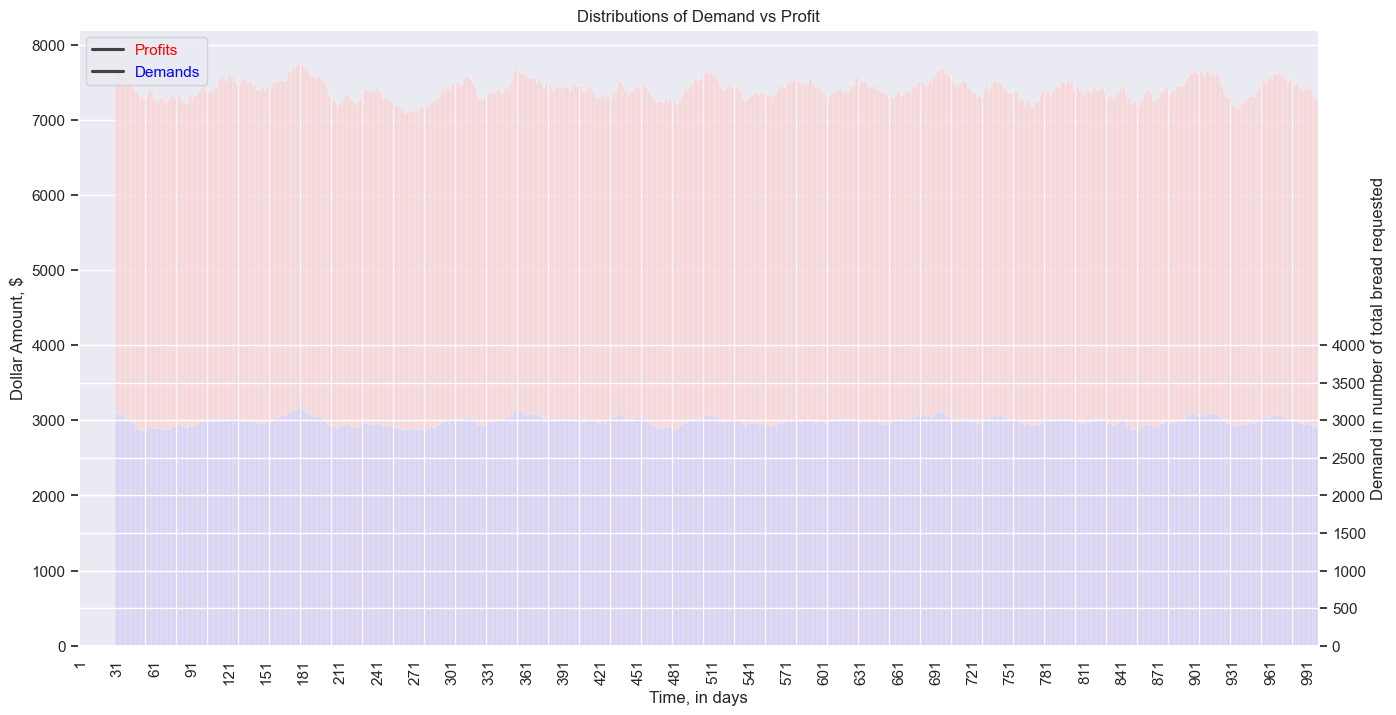

In [18]:
sns.set(rc = {'figure.figsize': (16, 8)}) #seaborn set figure size

#figure
fig, ax1 = plt.subplots()

#Plot profits as a bar chart with a rolling sum of 30 days = 1 month
sns.barplot(x = profits.index, y = profits.sum(axis = 1).rolling(30).sum(), color="red", alpha = 0.5) 
#Plot demands as a bar chart with a rolling sum of 30 days = 1 month
sns.barplot(x = demands.index, y = demands.sum(axis = 1).rolling(30).sum(), color="blue", alpha = 0.5)

#add labels
plt.legend(['Profits', 'Demands'], labelcolor=['red','blue']) #add legend
plt.xlabel("Time, in days") #add xaxis label
plt.xticks(range(1, 1000, 30),rotation = 90) #edit xaxis scale
plt.ylabel("Dollar Amount, $") #add yaxis label
plt.title("Distributions of Demand vs Profit") #add plot title

#twin the x-axis for a second axes
ax2 = ax1.twinx() 
ax2.set_ylim(ax1.get_ylim())
ax2.set_yticks(range(0,4500,500))
ax2.set_yticklabels(range(0,4500,500))
ax2.set_ylabel("Demand in number of total bread requested")

plt.show()

A good day for Profit is when the revenue (money made off sales from demand) is greater than the costs (cost to supply bread), so profit is positive.  
A bad day for Profit is when the revenue (money made off sales from demand) is less than the costs (cost to supply bread), so profit is negative.


So far we assumed that the supply of bread each day is fixed, but we can now loosen that assumption and ask what happens to profit if we increase or decrease the supply of bread, everything else being equal.

(6 / 6 prob) (42 / 42 points )
- Run `sim_profit` for the different values of `num_breads` as given by `num_breads_iter` shown below (all other arguments stay the same). Calculate the average profit (averaged over all the days) for each case and create a line plot showing number of breads supplied vs total profit. <span style="color:red" float:right>[5 point]</span>

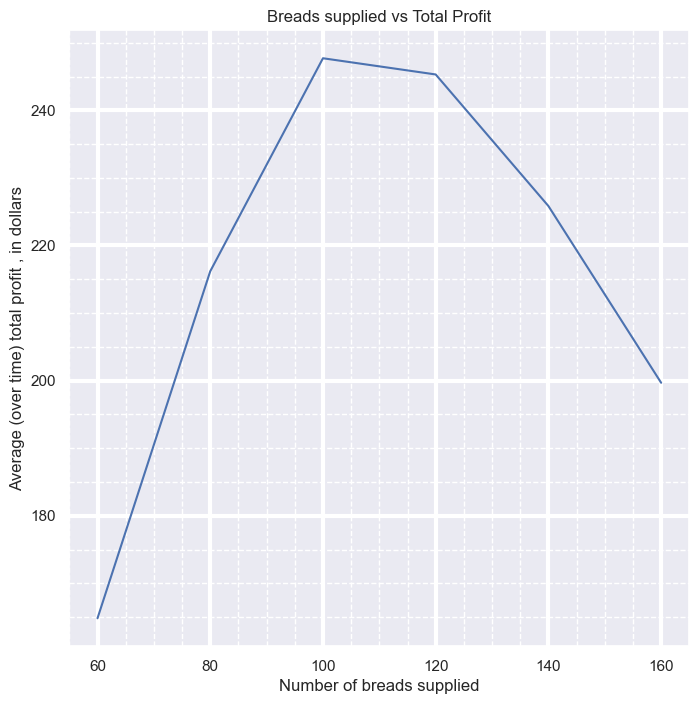

In [21]:
num_breads_iter = [60, 80, 100, 120, 140, 160]

list_supplies = [] #create an empty list
list_demands = []
list_profits = []
for each in num_breads_iter: #iterate over list
    supplies, demands, profits = sim_profit(num_breads = each, num_days = 1000, 
                                        arrival_rate = 100, sell_price = 4.00, cost_price = 1.25)
    list_supplies.append(supplies.sum(axis = 1).mean(axis = 0)) #find average supplies (Averaged over all the days)
    list_demands.append(demands.sum(axis = 1).mean(axis = 0)) #find average demands (averaged over all the days)
    list_profits.append(profits.sum(axis = 1).mean(axis = 0)) #find average profits (averaged over all the days)


sns.set(rc = {'figure.figsize': (8, 8)}) #seaborn set figure size

#create a line plot showing number of breads supplied vs total profit
ax = sns.lineplot(x = num_breads_iter, y = list_profits)
plt.xlabel("Number of breads supplied") #add xaxis label
plt.ylabel("Average (over time) total profit , in dollars") #add yaxis label
plt.title("Breads supplied vs Total Profit") #add plot title
ax.minorticks_on()
ax.grid(which='minor', linestyle='--')
ax.grid(which='major', linewidth = 3)

As you can see, once we can simulate daily profit, we can begin to answer many questions and reduce our uncertainty about the business. For this reason, Monte Carlo simulations can be an effective tool for measuring risk and reward.


# End of assignment